In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F  # Import functional API for Leaky ReLU
import torch.optim as optim

torch.manual_seed(42)

In [12]:
# Parameters
nx = 400  # Number of spatial grid points
L = 5.0  # Length of the domain
dt = 0.01  # Time step
a = 0.8  # Advection speed
T = 5.0  # Total simulation time
nt = int(T / dt)  # Number of time steps
dx = L / (nx - 1)  # Spatial resolution

# Grid points
x = np.linspace(0, L, nx)
t = np.linspace(0, T, int(T/dt))

CFL = a * dt / dx
print(f"CFL Number: {CFL}")

# Initial condition: Gaussian pulse
def initial_condition(x):
    return np.exp(-((x - L / 4) / 0.1) ** 2)

CFL Number: 0.6384000000000001


In [13]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 16)  # Input: (x, t)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = torch.sin(self.fc1(inputs))
        out = torch.sin(self.fc2(out))
        out = torch.sin(self.fc3(out))
        out = torch.sin(self.fc4(out))
        out = torch.sin(self.fc5(out))
        out = self.fc6(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()

    # Sample random collocation points
    num_samples = 100
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.choice(t, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 3*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

Epoch 0, Loss: 0.038053855299949646, PDE Loss: 0.00018272294255439192, IC Loss: 0.03703390434384346, Boundary Loss: 0.0004717832780443132
Epoch 1000, Loss: 0.0121212899684906, PDE Loss: 0.00024282344384118915, IC Loss: 0.011245953850448132, Boundary Loss: 0.00014686617942061275
Epoch 2000, Loss: 0.0023334273137152195, PDE Loss: 0.00036618526792153716, IC Loss: 0.0009424428571946919, Boundary Loss: 0.0002924288564827293
Epoch 3000, Loss: 0.0015816630329936743, PDE Loss: 0.0004229549376759678, IC Loss: 9.733170008985326e-05, Boundary Loss: 0.00021546646894421428
Epoch 4000, Loss: 0.0005775963654741645, PDE Loss: 5.38167187187355e-05, IC Loss: 0.00025754806119948626, Boundary Loss: 0.0001585981372045353
Epoch 5000, Loss: 0.001040983130224049, PDE Loss: 0.00022162235109135509, IC Loss: 4.391952097648755e-05, Boundary Loss: 0.000332196505041793
Epoch 6000, Loss: 0.0009588307584635913, PDE Loss: 0.00024021149147301912, IC Loss: 8.82364038261585e-05, Boundary Loss: 0.00014995985839050263
Epoc

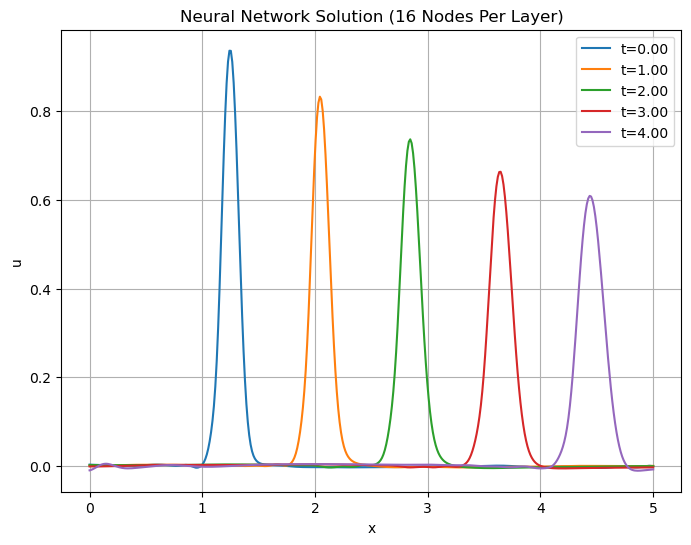

In [14]:
# Plot the results
plt.figure(figsize=(8, 6))
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot at specific time intervals
for n in range(5):
    t_test = torch.full_like(x_test, n) # Creates a vector with the same shape as x_test with a constant value equal to n
    with torch.no_grad(): 
        u_pred = model(x_test, t_test).detach().numpy()  # Detach tensor before converting to NumPy
    plt.plot(x, u_pred, label=f"t={n:.2f}")

plt.title('Neural Network Solution (16 Nodes Per Layer)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.savefig('plots/nn_16.png')
plt.show()

In [15]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 32)  # Input: (x, t)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 32)
        self.fc6 = nn.Linear(32, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = torch.sin(self.fc1(inputs))
        out = torch.sin(self.fc2(out))
        out = torch.sin(self.fc3(out))
        out = torch.sin(self.fc4(out))
        out = torch.sin(self.fc5(out))
        out = self.fc6(out)
        return out
    
# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()

    # Sample random collocation points
    num_samples = 100
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.choice(t, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 3*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

Epoch 0, Loss: 0.07215414196252823, PDE Loss: 3.781048872042447e-05, IC Loss: 0.07109390199184418, Boundary Loss: 0.0009468061616644263
Epoch 1000, Loss: 0.009446660056710243, PDE Loss: 7.009477121755481e-05, IC Loss: 0.00913975853472948, Boundary Loss: 9.661771036917344e-05
Epoch 2000, Loss: 0.001671269303187728, PDE Loss: 0.0002983938029501587, IC Loss: 0.0006353911594487727, Boundary Loss: 0.00014069672033656389
Epoch 3000, Loss: 0.0011727812234312296, PDE Loss: 0.0002132992958649993, IC Loss: 0.0003219876380171627, Boundary Loss: 0.00021089572692289948
Epoch 4000, Loss: 0.0009972987463697791, PDE Loss: 0.00024910859065130353, IC Loss: 7.622042176080868e-05, Boundary Loss: 0.00017375254537910223
Epoch 5000, Loss: 0.0010734302923083305, PDE Loss: 0.00027933725505135953, IC Loss: 0.00016409176168963313, Boundary Loss: 7.132667815312743e-05
Epoch 6000, Loss: 0.0003647356352303177, PDE Loss: 5.170650911168195e-05, IC Loss: 0.000107614352600649, Boundary Loss: 0.00010200174438068643
Epoc

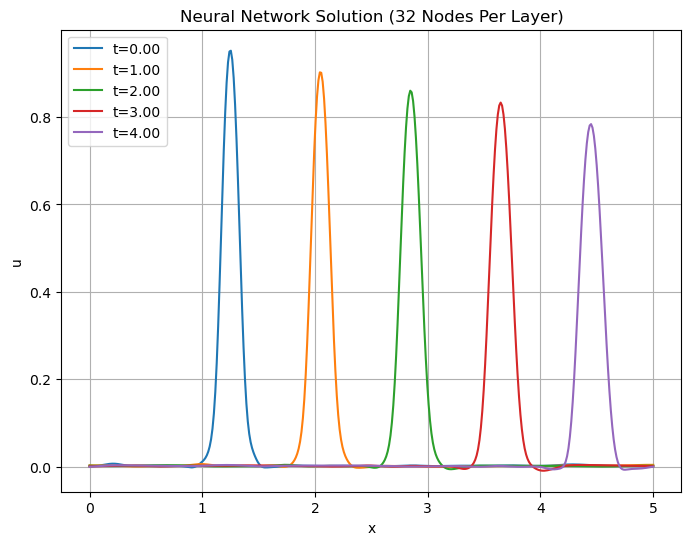

In [16]:
# Plot the results
plt.figure(figsize=(8, 6))
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot at specific time intervals
for n in range(5):
    t_test = torch.full_like(x_test, n) # Creates a vector with the same shape as x_test with a constant value equal to n
    with torch.no_grad(): 
        u_pred = model(x_test, t_test).detach().numpy()  # Detach tensor before converting to NumPy
    plt.plot(x, u_pred, label=f"t={n:.2f}")

plt.title('Neural Network Solution (32 Nodes Per Layer)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.savefig('plots/nn_32.png')
plt.show()

In [17]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input: (x, t)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = torch.sin(self.fc1(inputs))
        out = torch.sin(self.fc2(out))
        out = torch.sin(self.fc3(out))
        out = torch.sin(self.fc4(out))
        out = torch.sin(self.fc5(out))
        out = self.fc6(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()

    # Sample random collocation points
    num_samples = 100
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.choice(t, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 3*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

Epoch 0, Loss: 0.0050597828812897205, PDE Loss: 0.0005345229292288423, IC Loss: 0.002703980542719364, Boundary Loss: 0.0007522335508838296
Epoch 1000, Loss: 0.0022380463778972626, PDE Loss: 0.0003895921690855175, IC Loss: 0.0006229458376765251, Boundary Loss: 0.00044632412027567625
Epoch 2000, Loss: 0.0005843719700351357, PDE Loss: 0.00013729804777540267, IC Loss: 6.045382906449959e-05, Boundary Loss: 0.00011202397581655532
Epoch 3000, Loss: 0.0003054178669117391, PDE Loss: 6.879057036712766e-05, IC Loss: 5.5799566325731575e-05, Boundary Loss: 4.3246600398560986e-05
Epoch 4000, Loss: 9.94399597402662e-05, PDE Loss: 8.494304893247318e-06, IC Loss: 1.9799625079031102e-05, Boundary Loss: 5.4157422709977254e-05
Epoch 5000, Loss: 9.774604404810816e-05, PDE Loss: 2.171072264900431e-05, IC Loss: 1.0686938367143739e-05, Boundary Loss: 2.192693682445679e-05
Epoch 6000, Loss: 3.537679003784433e-05, PDE Loss: 5.110826350573916e-06, IC Loss: 3.494495558697963e-06, Boundary Loss: 1.654981679166667e

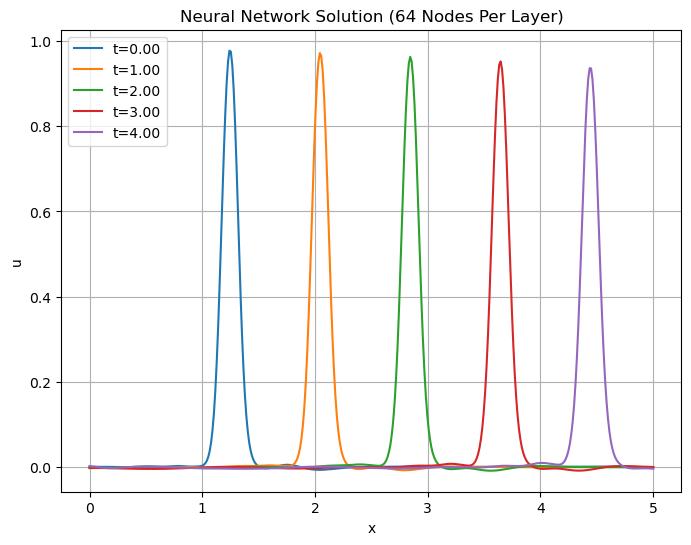

In [18]:
# Plot the results
plt.figure(figsize=(8, 6))
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot at specific time intervals
for n in range(5):
    t_test = torch.full_like(x_test, n) # Creates a vector with the same shape as x_test with a constant value equal to n
    with torch.no_grad(): 
        u_pred = model(x_test, t_test).detach().numpy()  # Detach tensor before converting to NumPy
    plt.plot(x, u_pred, label=f"t={n:.2f}")

plt.title('Neural Network Solution (64 Nodes Per Layer)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.savefig('plots/nn_64.png')
plt.show()

In [19]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 128)  # Input: (x, t)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = torch.sin(self.fc1(inputs))
        out = torch.sin(self.fc2(out))
        out = torch.sin(self.fc3(out))
        out = torch.sin(self.fc4(out))
        out = torch.sin(self.fc5(out))
        out = self.fc6(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()

    # Sample random collocation points
    num_samples = 100
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.choice(t, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 3*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

Epoch 0, Loss: 0.04980824515223503, PDE Loss: 0.00022706683375872672, IC Loss: 0.0412924662232399, Boundary Loss: 0.007834579795598984
Epoch 1000, Loss: 0.0037894623819738626, PDE Loss: 0.000319376471452415, IC Loss: 0.00277561042457819, Boundary Loss: 5.5722772231092677e-05
Epoch 2000, Loss: 0.0005572827067226171, PDE Loss: 8.544149022782221e-05, IC Loss: 0.0001526099513284862, Boundary Loss: 0.00014834826288279146
Epoch 3000, Loss: 0.0001641642884351313, PDE Loss: 2.3087646695785224e-05, IC Loss: 5.722340210922994e-05, Boundary Loss: 3.767794987652451e-05
Epoch 4000, Loss: 0.0002618306316435337, PDE Loss: 1.9067763787461445e-05, IC Loss: 8.232435357058421e-05, Boundary Loss: 0.00012230298307258636
Epoch 5000, Loss: 6.303975533228368e-05, PDE Loss: 1.1581273611227516e-05, IC Loss: 5.805020464322297e-06, Boundary Loss: 2.2490916308015585e-05
Epoch 6000, Loss: 4.920908759231679e-05, PDE Loss: 4.388682555145351e-06, IC Loss: 2.0233297618688084e-05, Boundary Loss: 1.5809742762940004e-05
E

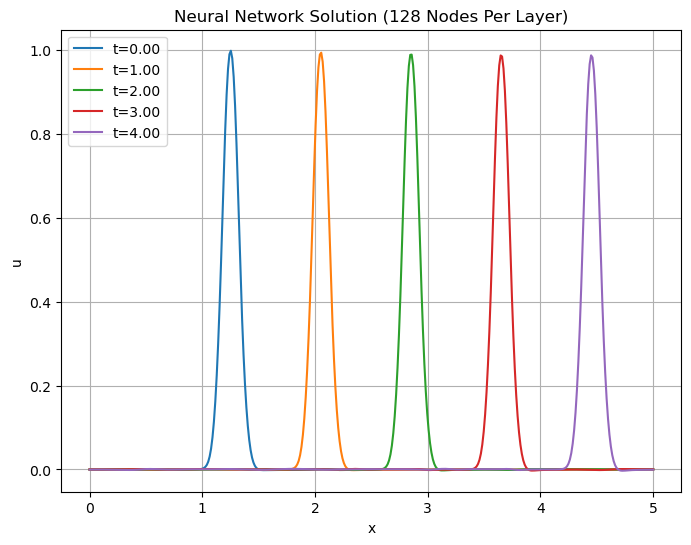

In [20]:
# Plot the results
plt.figure(figsize=(8, 6))
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot at specific time intervals
for n in range(5):
    t_test = torch.full_like(x_test, n) # Creates a vector with the same shape as x_test with a constant value equal to n
    with torch.no_grad(): 
        u_pred = model(x_test, t_test).detach().numpy()  # Detach tensor before converting to NumPy
    plt.plot(x, u_pred, label=f"t={n:.2f}")

plt.title('Neural Network Solution (128 Nodes Per Layer)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.savefig('plots/nn_128.png')
plt.show()